In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import random
import os 
from tqdm import tqdm 
import plotly.io as pio


import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

## 1. Import dataset

In [2]:
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=transform)

In [3]:
# Making sure that cleaning labels for unsupervised learning model

x_train = train_dataset.data
x_test = test_dataset.data
y_train = train_dataset.targets # labels stays with this line, so we do not take them.
y_test = test_dataset.targets

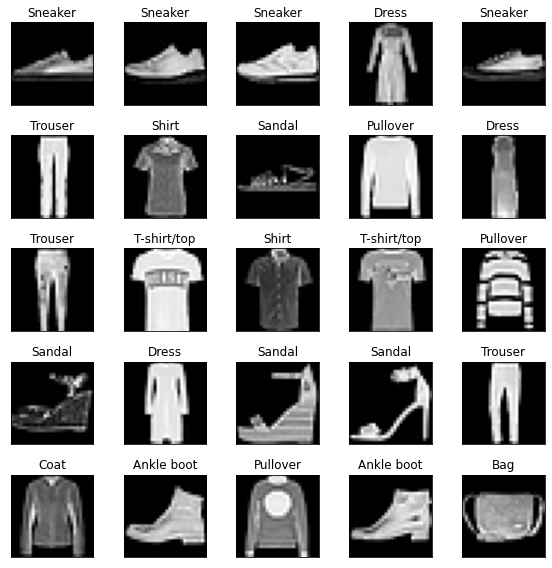

In [4]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))

labels_name = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.squeeze(np.array(img)), cmap='gist_gray')
    ax.set_title(labels_name[int(label)])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [5]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [6]:
l=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(l-l*0.2), int(l*0.2)])

batch_size=20

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## 2. Define Convolutional Autoencoder

In [29]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        #Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(p=.2),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Dropout(p=.2),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        #Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        #Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
 
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

In [30]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

    
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )
        
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.Dropout(p=.2),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.Dropout(p=.1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [31]:
torch.manual_seed(0)

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = Encoder(encoded_space_dim=4,fc2_input_dim=784)
        self.decoder = Decoder(encoded_space_dim=4,fc2_input_dim=784)
        
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded, encoded  

## 3. Initialize Loss function and the optimizer

In [32]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image

model = AutoEncoder()

dec_img, img_enc = model.forward(img)
print('Encoded image shape:', img_enc.shape)


#dec_img = model(img)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 4])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [33]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001
#lr = 0.0008 # Learning rate

params_to_optimize = [
    {'params': model.encoder.parameters()},
    {'params': model.decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
#optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=6e-05)

# Checking if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
model.encoder.to(device)
model.decoder.to(device)
#model.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.1, inplace=False)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## 4. Train and evaluate model

In [34]:
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    model.encoder.train()
    model.decoder.train()
    # Iterate the dataloader (we DO NOT NEED the label values, this is UNSUPERVISED learning)
    for image_batch, _ in dataloader: 
        # we ignore the labels here by _
        image_batch = image_batch.to(device)
        encoded_data = model.encoder(image_batch)
        decoded_data = model.decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        # Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.data

In [35]:
### Testing function
def test_epoch(model, device, dataloader, loss_fn):
    model.encoder.eval()
    model.decoder.eval()
    with torch.no_grad():
        # Defining the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch,_ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = model.encoder(image_batch)
            decoded_data = model.decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss

In [38]:
# This function allows us to see the reconstructred images during the training process
# It plots the original function first
# Then, it plots the reconstructed image secondly

def plot_reconstructed_images(model,n=5):
    
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      model.encoder.eval()
      model.decoder.eval()
      with torch.no_grad():
         rec_img  = model.decoder(model.encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original image')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed image')
    plt.show()   


 Epoch number 1/20 	 train loss 0.023523755371570587 	 val loss 0.02188085950911045


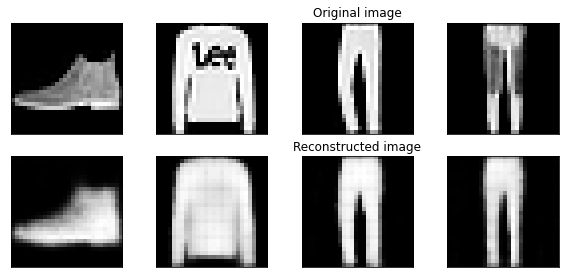


 Epoch number 2/20 	 train loss 0.024214433506131172 	 val loss 0.021669166162610054


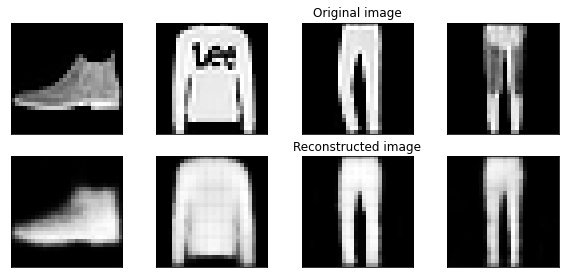


 Epoch number 3/20 	 train loss 0.023807253688573837 	 val loss 0.021336691454052925


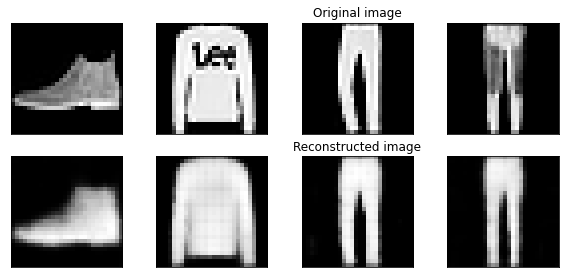


 Epoch number 4/20 	 train loss 0.023987235501408577 	 val loss 0.021405979990959167


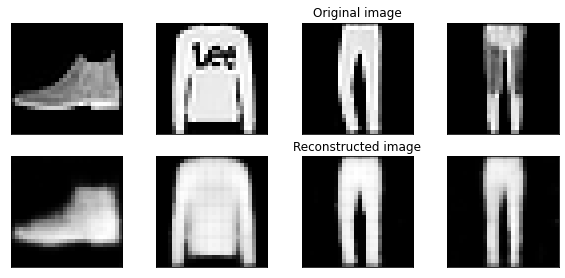

Early Stopped, validation loss is getting high!


In [39]:
num_epochs = 20
# For now I keep the number of epochs small due to the computational source problems
history={'train_loss':[],'val_loss':[]}

valid_loss_min = np.Inf

for epoch in range(num_epochs):

   train_loss = train_epoch(model,device,train_loader,loss_fn,optim)
   val_loss = test_epoch(model,device,valid_loader,loss_fn)
   print(f'\n Epoch number {epoch + 1}/{num_epochs} \t train loss {train_loss} \t val loss {val_loss}')
   history['train_loss'].append(train_loss)
   history['val_loss'].append(val_loss)
   
   # Early Stopping Regularization
   plot_reconstructed_images(model,n=4)

   if val_loss <= valid_loss_min:
      valid_loss_min = val_loss
   else: 
      print("Early Stopped, validation loss is getting high!")
      break;
   

[I 2021-12-04 15:20:11,881] A new study created in memory with name: no-name-3bc4bd8d-2f24-41ce-8236-a30f812a116a


In epoch 0, Training Error: 0.028606988489627838, Validation Loss: 0.028836999088525772
In epoch 1, Training Error: 0.03284892439842224, Validation Loss: 0.028757696971297264
In epoch 2, Training Error: 0.030707402154803276, Validation Loss: 0.027364233508706093
In epoch 3, Training Error: 0.035346869379282, Validation Loss: 0.02830549329519272
In epoch 4, Training Error: 0.03422655910253525, Validation Loss: 0.027806207537651062
In fold 0, Mean Accuracy is : 0.9721937775611877



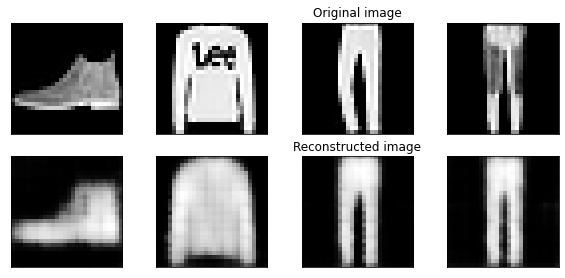

In epoch 0, Training Error: 0.0278594009578228, Validation Loss: 0.027808701619505882
In epoch 1, Training Error: 0.030079839751124382, Validation Loss: 0.027819829061627388
In epoch 2, Training Error: 0.035970304161310196, Validation Loss: 0.02753586135804653
In epoch 3, Training Error: 0.023311438038945198, Validation Loss: 0.026843177154660225
In epoch 4, Training Error: 0.03311256691813469, Validation Loss: 0.026899944990873337
In fold 1, Mean Accuracy is : 0.9731000661849976



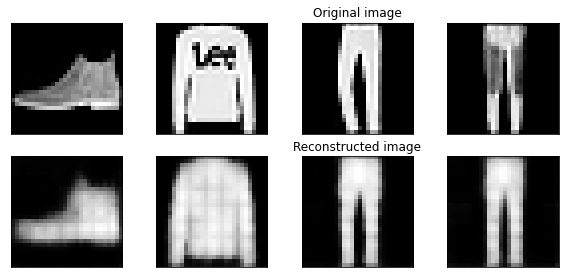

In epoch 0, Training Error: 0.0319085493683815, Validation Loss: 0.02745630592107773
In epoch 1, Training Error: 0.028026027604937553, Validation Loss: 0.026435624808073044
In epoch 2, Training Error: 0.03551866486668587, Validation Loss: 0.028971480205655098
In epoch 3, Training Error: 0.02766943909227848, Validation Loss: 0.027736663818359375
In epoch 4, Training Error: 0.03375519439578056, Validation Loss: 0.028158405795693398
In fold 2, Mean Accuracy is : 0.97184157371521



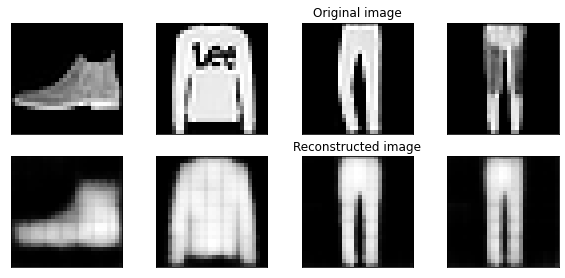

[I 2021-12-04 15:29:23,827] Trial 0 finished with value: 0.9723784923553467 and parameters: {'lr': 0.02434033331344916}. Best is trial 0 with value: 0.9723784923553467.


In epoch 0, Training Error: 0.03914078697562218, Validation Loss: 0.02775055728852749
In epoch 1, Training Error: 0.032687798142433167, Validation Loss: 0.026257585734128952
In epoch 2, Training Error: 0.03578966483473778, Validation Loss: 0.026660552248358727
In epoch 3, Training Error: 0.025232883170247078, Validation Loss: 0.02542792819440365
In epoch 4, Training Error: 0.02734086848795414, Validation Loss: 0.025852276012301445
In fold 0, Mean Accuracy is : 0.9741477370262146



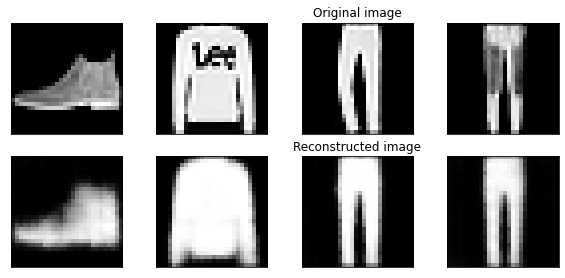

In epoch 0, Training Error: 0.02522847428917885, Validation Loss: 0.02645098604261875
In epoch 1, Training Error: 0.026799598708748817, Validation Loss: 0.026770949363708496
In epoch 2, Training Error: 0.029311491176486015, Validation Loss: 0.026075666770339012
In epoch 3, Training Error: 0.02975371852517128, Validation Loss: 0.026020193472504616
In epoch 4, Training Error: 0.031803447753190994, Validation Loss: 0.025864597409963608
In fold 1, Mean Accuracy is : 0.9741353988647461



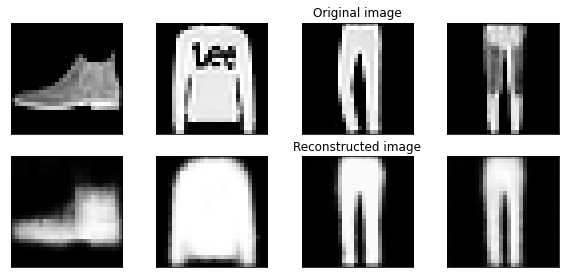

In epoch 0, Training Error: 0.03744068369269371, Validation Loss: 0.025832030922174454
In epoch 1, Training Error: 0.031046763062477112, Validation Loss: 0.02758476883172989
In epoch 2, Training Error: 0.029462244361639023, Validation Loss: 0.025876076892018318
In epoch 3, Training Error: 0.035670407116413116, Validation Loss: 0.025596855208277702
In epoch 4, Training Error: 0.03517664596438408, Validation Loss: 0.02525942213833332
In fold 2, Mean Accuracy is : 0.9747405648231506



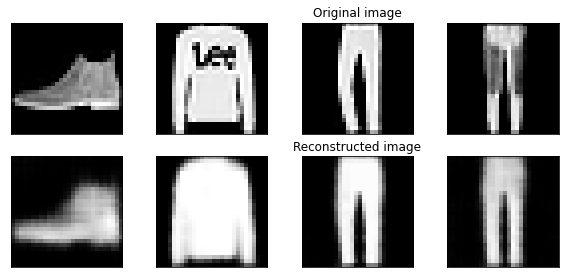

[I 2021-12-04 15:37:23,835] Trial 1 finished with value: 0.9743412137031555 and parameters: {'lr': 0.01357834311323048}. Best is trial 1 with value: 0.9743412137031555.


In epoch 0, Training Error: 0.03184639662504196, Validation Loss: 0.02685997448861599
In epoch 1, Training Error: 0.02794548124074936, Validation Loss: 0.027281269431114197
In epoch 2, Training Error: 0.025932786986231804, Validation Loss: 0.02635178342461586
In epoch 3, Training Error: 0.028050914406776428, Validation Loss: 0.02673802338540554
In epoch 4, Training Error: 0.02859305962920189, Validation Loss: 0.02613796666264534
In fold 0, Mean Accuracy is : 0.9738620519638062



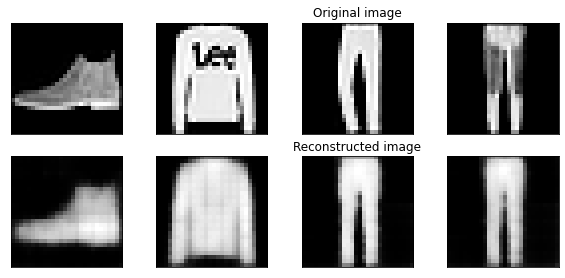

In epoch 0, Training Error: 0.031056107953190804, Validation Loss: 0.025780726224184036
In epoch 1, Training Error: 0.03434858098626137, Validation Loss: 0.02564494125545025
In epoch 2, Training Error: 0.03145134076476097, Validation Loss: 0.025219451636075974
In epoch 3, Training Error: 0.027796577662229538, Validation Loss: 0.02583092823624611
In epoch 4, Training Error: 0.02623925544321537, Validation Loss: 0.02615087851881981
In fold 1, Mean Accuracy is : 0.9738491177558899



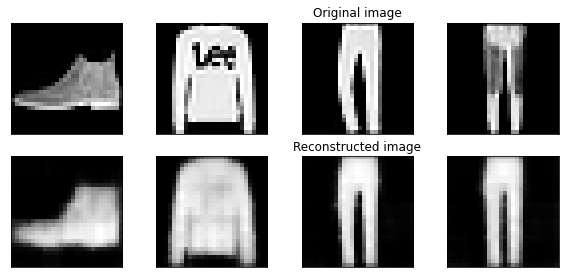

In epoch 0, Training Error: 0.02828814648091793, Validation Loss: 0.026850704103708267
In epoch 1, Training Error: 0.029944507405161858, Validation Loss: 0.025003407150506973
In epoch 2, Training Error: 0.027967210859060287, Validation Loss: 0.02576531283557415
In epoch 3, Training Error: 0.034439630806446075, Validation Loss: 0.026860587298870087
In epoch 4, Training Error: 0.02704283967614174, Validation Loss: 0.026069894433021545
In fold 2, Mean Accuracy is : 0.9739301204681396



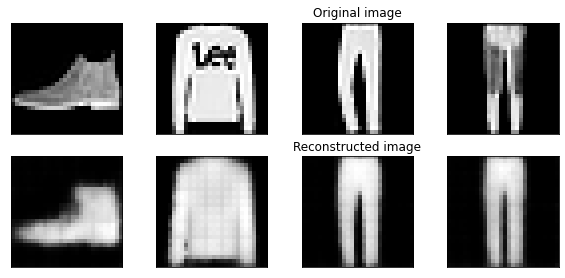

[I 2021-12-04 15:46:13,161] Trial 2 finished with value: 0.9738804697990417 and parameters: {'lr': 0.013811047610155013}. Best is trial 1 with value: 0.9743412137031555.


In [40]:
import optuna
from sklearn.model_selection import KFold

def objective(trial,fold_idx, train_loader,valid_loader,loss_fn, model):
    
    
    params_to_optimize = [
        {'params': model.encoder.parameters()},
        {'params': model.decoder.parameters()}
    ]
   
    history={'train_loss':[],'val_loss':[]}
    
    lr = trial.suggest_float('lr', 0.01, 0.03 )
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

    for epoch in range(5):
       train_loss = train_epoch(model,device,train_loader,loss_fn,optim)
       val_loss = test_epoch(model,device,valid_loader,loss_fn)
       print(f"In epoch {epoch}, Training Error: {train_loss}, Validation Loss: {val_loss}")
    #let's return accuracy and aim of maximizing the accuracy 
    return 1-val_loss

# created another function here to implement cross-validation
def objective_cv(trial):

    # Get the MNIST dataset.
    #num_epochs = trial.suggest_int('num_epochs', 3)
    loss_fn = torch.nn.MSELoss()
    model = AutoEncoder()
    
    fold = KFold(n_splits=3, shuffle=True, random_state=0)
    scores = []
    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(range(len(train_dataset)))):
        train_data = torch.utils.data.Subset(train_dataset, train_idx)
        valid_data = torch.utils.data.Subset(train_dataset, valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_data,
            batch_size=20,
            shuffle=True,
        )
        valid_loader = torch.utils.data.DataLoader(
            valid_data,
            batch_size=20,
            shuffle=True,
        )

        accuracy = objective(trial, fold_idx, train_loader, valid_loader, loss_fn, model)
        print(f"In fold {fold_idx}, Mean Accuracy is : {accuracy}\n")
        scores.append(accuracy)
        plot_reconstructed_images(model,n=4)
        

        
    return np.mean(scores)


study = optuna.create_study(direction="maximize")
study.optimize(objective_cv, n_trials=3)

[I 2021-12-04 15:46:13,175] A new study created in memory with name: no-name-bfb95ae7-8cb6-472c-91c2-9279db2d43ad


In epoch 0, Training Error: 0.0765131413936615, Validation Loss: 0.08333110809326172
In epoch 1, Training Error: 0.06900078803300858, Validation Loss: 0.059108685702085495
In epoch 2, Training Error: 0.053213149309158325, Validation Loss: 0.048706330358982086
In epoch 3, Training Error: 0.04485335201025009, Validation Loss: 0.04439685866236687
In epoch 4, Training Error: 0.04599018767476082, Validation Loss: 0.042235132306814194
In fold 0, Mean Accuracy is : 0.9577648639678955



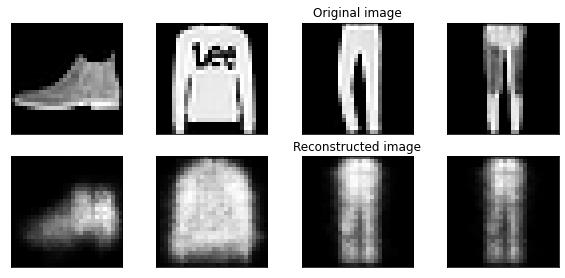

In epoch 0, Training Error: 0.0406356155872345, Validation Loss: 0.0403439886868
In epoch 1, Training Error: 0.04483598470687866, Validation Loss: 0.0384029746055603
In epoch 2, Training Error: 0.04149298369884491, Validation Loss: 0.03714877367019653
In epoch 3, Training Error: 0.04286981001496315, Validation Loss: 0.037988800555467606
In epoch 4, Training Error: 0.04117699712514877, Validation Loss: 0.035944197326898575
In fold 1, Mean Accuracy is : 0.9640557765960693



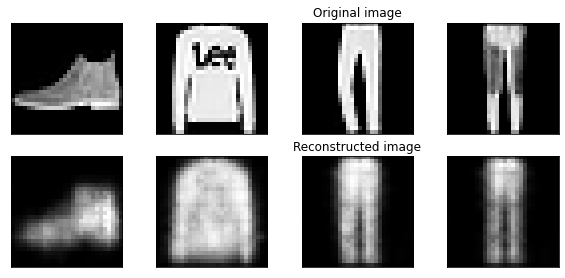

In epoch 0, Training Error: 0.039009999483823776, Validation Loss: 0.03530528396368027
In epoch 1, Training Error: 0.04638992249965668, Validation Loss: 0.03570697829127312
In epoch 2, Training Error: 0.039927221834659576, Validation Loss: 0.034621212631464005
In epoch 3, Training Error: 0.03705247864127159, Validation Loss: 0.03368419036269188
In epoch 4, Training Error: 0.047205083072185516, Validation Loss: 0.035639870911836624
In fold 2, Mean Accuracy is : 0.9643601179122925



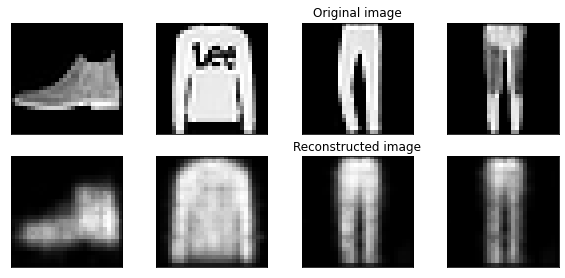

[I 2021-12-04 15:51:55,429] Trial 0 finished with value: 0.962060272693634 and parameters: {'lr': 0.021274380476794447}. Best is trial 0 with value: 0.962060272693634.


In epoch 0, Training Error: 0.10180336236953735, Validation Loss: 0.09688720852136612
In epoch 1, Training Error: 0.09598062187433243, Validation Loss: 0.08224289119243622
In epoch 2, Training Error: 0.07008811086416245, Validation Loss: 0.05945270508527756
In epoch 3, Training Error: 0.05151748284697533, Validation Loss: 0.04694611206650734
In epoch 4, Training Error: 0.04579481482505798, Validation Loss: 0.04151008278131485
In fold 0, Mean Accuracy is : 0.9584898948669434



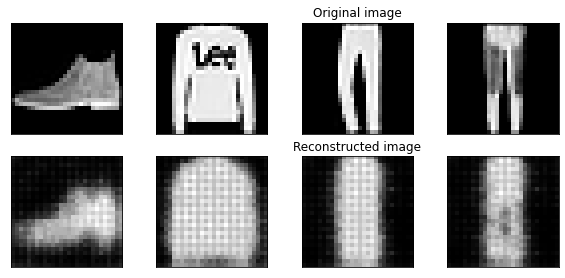

In epoch 0, Training Error: 0.043074727058410645, Validation Loss: 0.03826068341732025
In epoch 1, Training Error: 0.04317788407206535, Validation Loss: 0.03616409748792648
In epoch 2, Training Error: 0.037414733320474625, Validation Loss: 0.03460313007235527
In epoch 3, Training Error: 0.03486154228448868, Validation Loss: 0.03319902718067169
In epoch 4, Training Error: 0.0364280641078949, Validation Loss: 0.03209160640835762
In fold 1, Mean Accuracy is : 0.9679083824157715



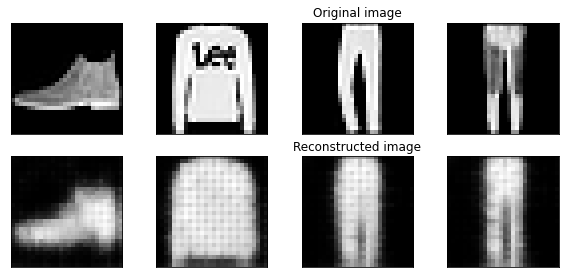

In epoch 0, Training Error: 0.03507759049534798, Validation Loss: 0.031162431463599205
In epoch 1, Training Error: 0.03795148432254791, Validation Loss: 0.030470775440335274
In epoch 2, Training Error: 0.03568898141384125, Validation Loss: 0.029807766899466515
In epoch 3, Training Error: 0.03278183192014694, Validation Loss: 0.02944718860089779
In epoch 4, Training Error: 0.03799405321478844, Validation Loss: 0.028988458216190338
In fold 2, Mean Accuracy is : 0.9710115194320679



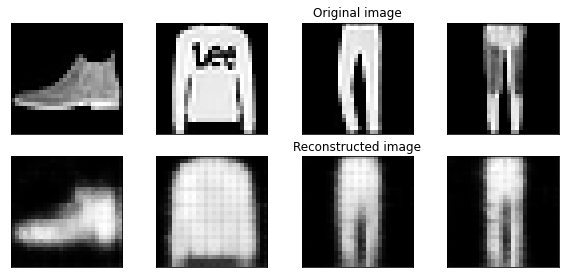

[I 2021-12-04 15:57:58,020] Trial 1 finished with value: 0.965803325176239 and parameters: {'lr': 0.022029506480938325}. Best is trial 1 with value: 0.965803325176239.


In epoch 0, Training Error: 0.08366581052541733, Validation Loss: 0.08336087316274643
In epoch 1, Training Error: 0.052957870066165924, Validation Loss: 0.04860737547278404
In epoch 2, Training Error: 0.042779579758644104, Validation Loss: 0.03841296210885048
In epoch 3, Training Error: 0.036261945962905884, Validation Loss: 0.035022709518671036
In epoch 4, Training Error: 0.03381254896521568, Validation Loss: 0.033277224749326706
In fold 0, Mean Accuracy is : 0.9667227864265442



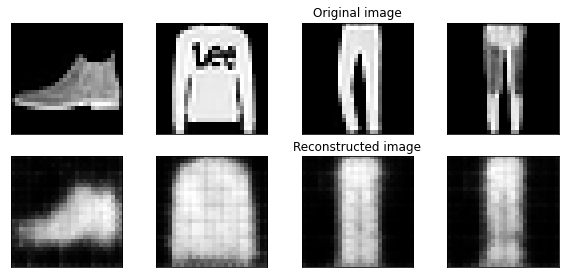

In epoch 0, Training Error: 0.038321930915117264, Validation Loss: 0.03190283104777336
In epoch 1, Training Error: 0.03567149117588997, Validation Loss: 0.03117443062365055
In epoch 2, Training Error: 0.040614109486341476, Validation Loss: 0.03019964136183262
In epoch 3, Training Error: 0.033338598906993866, Validation Loss: 0.029234275221824646
In epoch 4, Training Error: 0.03243168815970421, Validation Loss: 0.02848951146006584
In fold 1, Mean Accuracy is : 0.9715104699134827



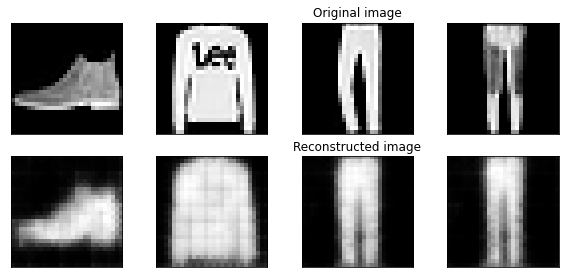

In epoch 0, Training Error: 0.030733399093151093, Validation Loss: 0.028436774387955666
In epoch 1, Training Error: 0.030033184215426445, Validation Loss: 0.02777828276157379
In epoch 2, Training Error: 0.02914843149483204, Validation Loss: 0.027604425325989723
In epoch 3, Training Error: 0.028082603588700294, Validation Loss: 0.02760494127869606
In epoch 4, Training Error: 0.02946152351796627, Validation Loss: 0.027424799278378487
In fold 2, Mean Accuracy is : 0.9725751876831055



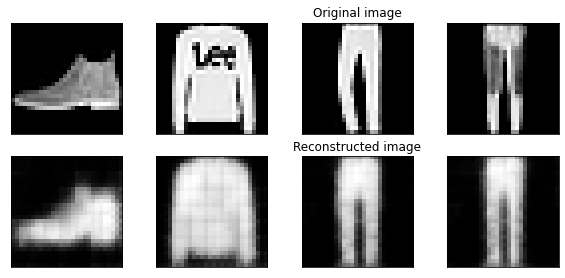

[I 2021-12-04 16:03:34,631] Trial 2 finished with value: 0.970269501209259 and parameters: {'lr': 0.02848245434941231}. Best is trial 2 with value: 0.970269501209259.


In [41]:
import optuna
from sklearn.model_selection import KFold

def objective(trial,fold_idx, train_loader,valid_loader,loss_fn, model):
    
    
    params_to_optimize = [
        {'params': model.encoder.parameters()},
        {'params': model.decoder.parameters()}
    ]
   
    history={'train_loss':[],'val_loss':[]}
    
    lr = trial.suggest_float('lr', 0.01, 0.03 )
    optim = torch.optim.SGD(params_to_optimize, lr=lr, weight_decay=1e-05)

    for epoch in range(5):
       train_loss = train_epoch(model,device,train_loader,loss_fn,optim)
       val_loss = test_epoch(model,device,valid_loader,loss_fn)
       print(f"In epoch {epoch}, Training Error: {train_loss}, Validation Loss: {val_loss}")
    #let's return accuracy and aim of maximizing the accuracy 
    return 1-val_loss

# created another function here to implement cross-validation
def objective_cv(trial):

    # Get the MNIST dataset.
    #num_epochs = trial.suggest_int('num_epochs', 3)
    loss_fn = torch.nn.MSELoss()
    model = AutoEncoder()
    
    fold = KFold(n_splits=3, shuffle=True, random_state=0)
    scores = []
    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(range(len(train_dataset)))):
        train_data = torch.utils.data.Subset(train_dataset, train_idx)
        valid_data = torch.utils.data.Subset(train_dataset, valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_data,
            batch_size=20,
            shuffle=True,
        )
        valid_loader = torch.utils.data.DataLoader(
            valid_data,
            batch_size=20,
            shuffle=True,
        )

        accuracy = objective(trial, fold_idx, train_loader, valid_loader, loss_fn, model)
        print(f"In fold {fold_idx}, Mean Accuracy is : {accuracy}\n")
        scores.append(accuracy)
        plot_reconstructed_images(model,n=4)
        

        
    return np.mean(scores)


study = optuna.create_study(direction="maximize")
study.optimize(objective_cv, n_trials=3)

In [42]:
test_epoch(model,device,test_loader,loss_fn).item()

0.021467363461852074

## 6. Visualize Latent Code 

In [44]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    model.encoder.eval()
    with torch.no_grad():
        encoded_img  = model.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:07<00:00, 1257.74it/s]


In [45]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,1.047167,-0.524020,-0.901625,0.268503,9
1,-2.339385,-0.523699,0.003594,-1.593651,2
2,0.881957,1.336409,4.020283,-0.511478,1
3,1.031790,1.444804,1.836199,-0.481898,1
4,-0.965340,-0.303654,0.361453,-0.193749,6
...,...,...,...,...,...
9995,1.007386,-1.736291,-0.860071,1.025360,9
9996,0.575982,1.068651,0.821480,-0.227088,1
9997,0.053377,1.356962,-0.979703,0.967171,8
9998,1.257452,2.350223,2.039232,0.589731,1


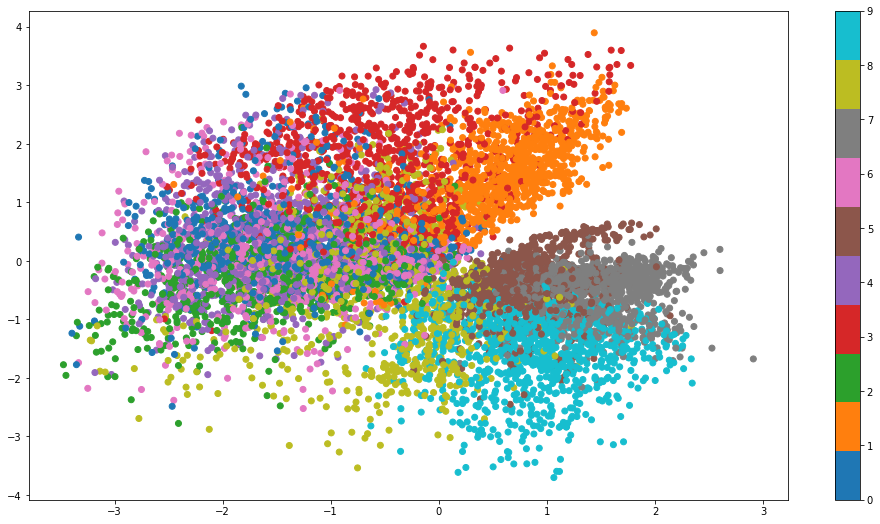

In [46]:
plt.figure(figsize=(17, 9))
plt.scatter(encoded_samples['Enc. Variable 0'], encoded_samples['Enc. Variable 1'], c=encoded_samples.label, cmap='tab10')
plt.colorbar()
plt.show()

In [47]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

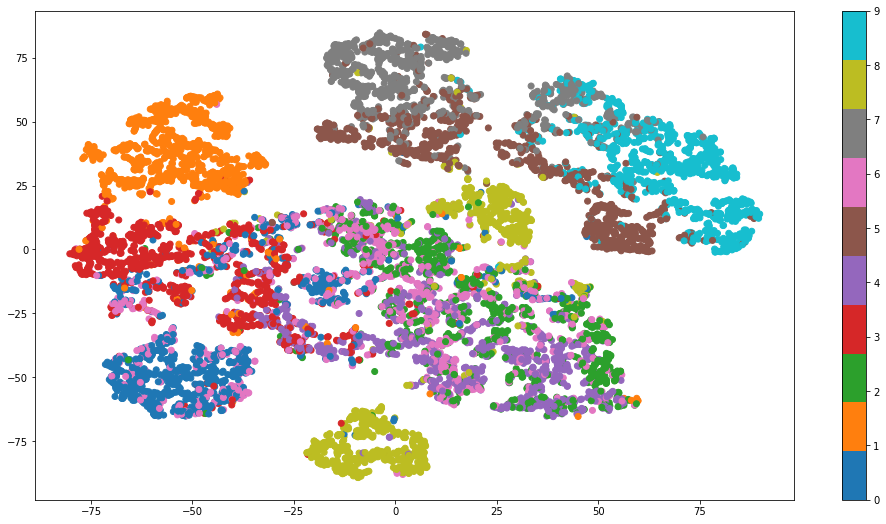

In [48]:
plt.figure(figsize=(17, 9))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=encoded_samples.label, cmap='tab10')
plt.colorbar()
plt.show()

**VCAE IMPLEMENTATION EXPERIMENT**

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [51]:
class VAE(nn.Module):
    def __init__(self, ch=1, feature_dimensions=32*20*20, z_dimension=256):
        super(VAE, self).__init__()
        
        self.encConv1 = nn.Conv2d(ch, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5)
        self.encFC1 = nn.Linear(feature_dimensions, z_dimension)
        self.encFC2 = nn.Linear(feature_dimensions, z_dimension)

        self.decFC1 = nn.Linear(z_dimension, feature_dimensions)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, ch, 5)

    def encoder(self, x):

        #predict mean (meanvec) and variance ( variance )
        # Meanvec and variancevec are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*20*20)
        meanvec = self.encFC1(x)
        variancevec = self.encFC2(x)
        return meanvec, variancevec

    def reparameterize(self, meanvec, variancevec):

        #Here we are introducing the standard deviation vector and mean vector, 
        #specific to the variational autoencoders
        std = torch.exp(variancevec/2)
        eps = torch.randn_like(std)
        return meanvec + std * eps
    
    def decoder(self, z):
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32, 20, 20)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

    def forward(self, x):

        # The VAE: encoder -> reparameterization -> decoder
        # output, meanvec, and variancevec are returned for loss computation
        meanvec, variancevec = self.encoder(x)
        z = self.reparameterize(meanvec, variancevec)
        out = self.decoder(z)
        return out, meanvec, variancevec

In [52]:
batch_size = 128
learning_rate = 0.01
num_epochs = 20

train_loader = torch.utils.data.DataLoader( datasets.FashionMNIST('data', train=True, download=True,transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader( datasets.FashionMNIST('data', train=False, transform=transforms.ToTensor()), batch_size=1)


net = VAE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for idx, data in enumerate(train_loader, 0):
        imgs, _ = data
        imgs = imgs.to(device)

        # Feeding a batch of images into the network to obtain the output image, mean, and variance
        out, meanvec, variancevec = net(imgs)

        # The loss is the BCE loss combined with the KL divergence to ensure the distribution 
        kl_divergence = 0.5 * torch.sum(-1 - variancevec + meanvec.pow(2) + variancevec.exp())
        loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch {}: Loss {}'.format(epoch, loss))

/Users/rabiayapicioglu/opt/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: Loss 37670.94921875
Epoch 1: Loss 37097.06640625
Epoch 2: Loss 36884.91015625
Epoch 3: Loss 37115.9375
Epoch 4: Loss 37332.95703125
Epoch 5: Loss 37364.1875
Epoch 6: Loss 37149.61328125
Epoch 7: Loss 36745.9296875
Epoch 8: Loss 36568.19921875
Epoch 9: Loss 36924.3671875
Epoch 10: Loss 37179.6875
Epoch 11: Loss 37139.51171875
Epoch 12: Loss 37793.55078125
Epoch 13: Loss 38057.9609375
Epoch 14: Loss 37895.94921875
Epoch 15: Loss 36936.3671875
Epoch 16: Loss 37348.23828125
Epoch 17: Loss 37184.71875
Epoch 18: Loss 37715.09375
Epoch 19: Loss 37266.203125


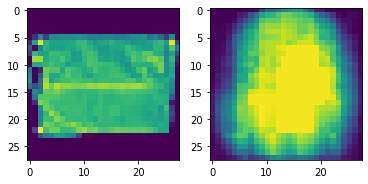

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import random

net.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        out, mu, logVAR = net(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        break

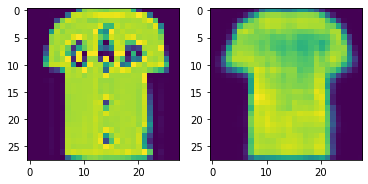

In [164]:
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        out, mu, logVAR = net(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        break

In [65]:
def plot_reconstructed_vae(net):
    net.eval()
    with torch.no_grad():
        for data in random.sample(list(test_loader), 1):
            imgs, _ = data
            imgs = imgs.to(device)
            img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
            plt.subplot(121)
            plt.imshow(np.squeeze(img))
            out, mu, logVAR = net(imgs)
            outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
            plt.subplot(122)
            plt.imshow(np.squeeze(outimg))
            break

In [66]:
def train_epoch_vae(model, device, train_loader, optimizer):
    model.train()
  
    batch_size = 128
    learning_rate = 0.01
    num_epochs = 3


    for epoch in range(num_epochs):
        for idx, data in enumerate(train_loader, 0):
            imgs, _ = data
            imgs = imgs.to(device)

            # Feeding a batch of images into the network to obtain the output image, mean, and variance
            out, meanvec, variancevec = net(imgs)

            # The loss is the BCE loss combined with the KL divergence to ensure the distribution 
            kl_divergence = 0.5 * torch.sum(-1 - variancevec + meanvec.pow(2) + variancevec.exp())
            loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence

            # Backpropagation based on the loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    return loss.data

In [67]:
def test_epoch_vae(model, device, dataloader):
    model.eval()
  
    with torch.no_grad():
        # Defining the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch,_ in dataloader:
            image_batch = image_batch.to(device)
            out, meanvec, variancevec = model(image_batch)
            kl_divergence = 0.5 * torch.sum(-1 - variancevec + meanvec.pow(2) + variancevec.exp())
            loss = F.binary_cross_entropy(out, image_batch, size_average=False) + kl_divergence
    return val_loss

In [68]:
# This function allows us to see the reconstructred images during the training process
# It plots the original function first
# Then, it plots the reconstructed image secondly

def plot_reconstructed_images_vae(model,n=5):
    
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      model.eval()
      with torch.no_grad():
         rec_img  = model.decoder(model.encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original image')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed image')
    plt.show()   

[I 2021-12-04 18:53:41,785] A new study created in memory with name: no-name-b05659ae-53e6-4d29-b2cc-37f994b8ce36
/Users/rabiayapicioglu/opt/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In epoch 0, Training Error: 24855.62890625, Validation Loss: 0.021405979990959167
In epoch 1, Training Error: 25139.32421875, Validation Loss: 0.021405979990959167
In fold 0, Mean Accuracy is : 0.9785940051078796

In epoch 0, Training Error: 25134.291015625, Validation Loss: 0.021405979990959167
In epoch 1, Training Error: 25088.12890625, Validation Loss: 0.021405979990959167
In fold 1, Mean Accuracy is : 0.9785940051078796



<ipython-input-65-5d0539e08c33>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-65-5d0539e08c33>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)


In epoch 0, Training Error: 24696.068359375, Validation Loss: 0.021405979990959167
In epoch 1, Training Error: 24612.43359375, Validation Loss: 0.021405979990959167
In fold 2, Mean Accuracy is : 0.9785940051078796



[I 2021-12-04 19:26:24,896] Trial 0 finished with value: 0.9785940051078796 and parameters: {'lr': 0.01639278262425243}. Best is trial 0 with value: 0.9785940051078796.
/Users/rabiayapicioglu/opt/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In epoch 0, Training Error: 25354.802734375, Validation Loss: 0.021405979990959167
In epoch 1, Training Error: 25189.41796875, Validation Loss: 0.021405979990959167
In fold 0, Mean Accuracy is : 0.9785940051078796



<ipython-input-65-5d0539e08c33>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-65-5d0539e08c33>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)


In epoch 0, Training Error: 24720.62109375, Validation Loss: 0.021405979990959167
In epoch 1, Training Error: 24949.31640625, Validation Loss: 0.021405979990959167
In fold 1, Mean Accuracy is : 0.9785940051078796

In epoch 0, Training Error: 25311.2265625, Validation Loss: 0.021405979990959167
In epoch 1, Training Error: 25538.55859375, Validation Loss: 0.021405979990959167
In fold 2, Mean Accuracy is : 0.9785940051078796



[I 2021-12-04 20:00:13,217] Trial 1 finished with value: 0.9785940051078796 and parameters: {'lr': 0.01143060580512036}. Best is trial 0 with value: 0.9785940051078796.


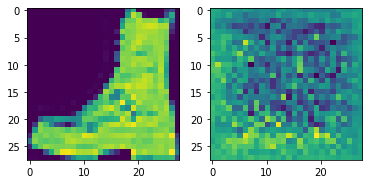

In [69]:
import optuna
from sklearn.model_selection import KFold

transform = transforms.ToTensor()

train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=transform)

def objective(trial,fold_idx, train_loader,valid_loader, model): 
    history={'train_loss':[],'val_loss':[]}
    
    lr = trial.suggest_float('lr', 0.01, 0.03 )
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-05)

    for epoch in range(2):
       train_loss = train_epoch_vae(model,device,train_loader,optim)
       val_loss = test_epoch_vae(model,device,valid_loader)
       print(f"In epoch {epoch}, Training Error: {train_loss}, Validation Loss: {val_loss}")
    #let's return accuracy and aim of maximizing the accuracy 
    return 1-val_loss

# created another function here to implement cross-validation
def objective_cv(trial):

    # Get the MNIST dataset.
    #num_epochs = trial.suggest_int('num_epochs', 3)
    
    model = VAE()
    fold = KFold(n_splits=3, shuffle=True, random_state=0)
    scores = []
    
    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(range(len(train_dataset)))):
        train_data = torch.utils.data.Subset(train_dataset, train_idx)
        valid_data = torch.utils.data.Subset(train_dataset, valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_data,
            batch_size=128,
            shuffle=True,
        )
        valid_loader = torch.utils.data.DataLoader(
            valid_data,
            batch_size=128,
            shuffle=True,
        )

        accuracy = objective(trial, fold_idx, train_loader, valid_loader, model)
        print(f"In fold {fold_idx}, Mean Accuracy is : {accuracy}\n")
        scores.append(accuracy)
        #plot_reconstructed_vae(model)
    
        
    return np.mean(scores)


study = optuna.create_study(direction="maximize")
study.optimize(objective_cv, n_trials=2)